In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
os.environ["MALLOC_TRIM_THRESHOLD_"] = '0'

import numpy as np
import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

from functionMaths import *

plt.rc("figure", figsize=(12,10))
plt.rc("font", size=14)

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, protocol = 'tcp', host = '137.129.155.67')
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 48231 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:48231/status,
Dashboard: http://137.129.155.67:48231/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: tcp://137.129.155.67:36753,Workers: 1
Dashboard: http://137.129.155.67:48231/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: tcp://137.129.155.67:44277,Total threads: 4
Dashboard: http://137.129.155.67:38729/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
wave_OLR = ['OLR_TD', 'OLR_MJO', 'OLR_Kelvin', 'OLR_Rossby', 'OLR_MRG', 'OLR_EIG','OLR_WIG']
indir_data = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/OLR/'
coeff = 1

### Opening data filter datasets
months =  [7,8,9]  # Months to selects
ds = xr.open_mfdataset(indir_data + '*.nc', chunks = {'time' : 10})
_ds = ds.sel(time = np.in1d(ds['time.month'], months), lon =slice(-5,5), lat = slice(9,19))
_ds = _ds.mean(dim = ['lat','lon'])

### Opening variance datasets
indir_var = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/VARIANCE/ANOMALY_FILTERED/OLR/'
ds_var = xr.open_mfdataset(indir_var + 'OLR_JAS_box_A.nc')
ds_DDt_var = xr.open_mfdataset(indir_var + 'OLR_DDT_JAS_box_A.nc')
ds_std = ds_var**(0.5)
ds_DDt_std = ds_DDt_var**(0.5)

In [3]:
### Compute temporal derivative
ds_DDt = ds.differentiate('time', datetime_unit = "s")
_ds_DDt = ds_DDt.sel(time = np.in1d(ds_DDt['time.month'], months), lon =slice(-5,5), lat = slice(9,19))
_ds_DDt = _ds_DDt.mean(dim = ['lat','lon'])

# Normalizing by standard deviation
ds_norm = _ds/ds_std
_ds_DDt = _ds_DDt/ds_DDt_std


### Stock in one datasets
for w in wave_OLR :
    ds_norm[w + '_DT'] = _ds_DDt[w]
    
### Compute variance of the data
ds_norm_std = ds_norm.std(dim = 'time')

v1 = ds_norm['OLR_Kelvin'].compute()
v2 = ds_norm['OLR_Kelvin_DT'].compute()

ds_plot = amplitudeMagnitude(v1, v2)


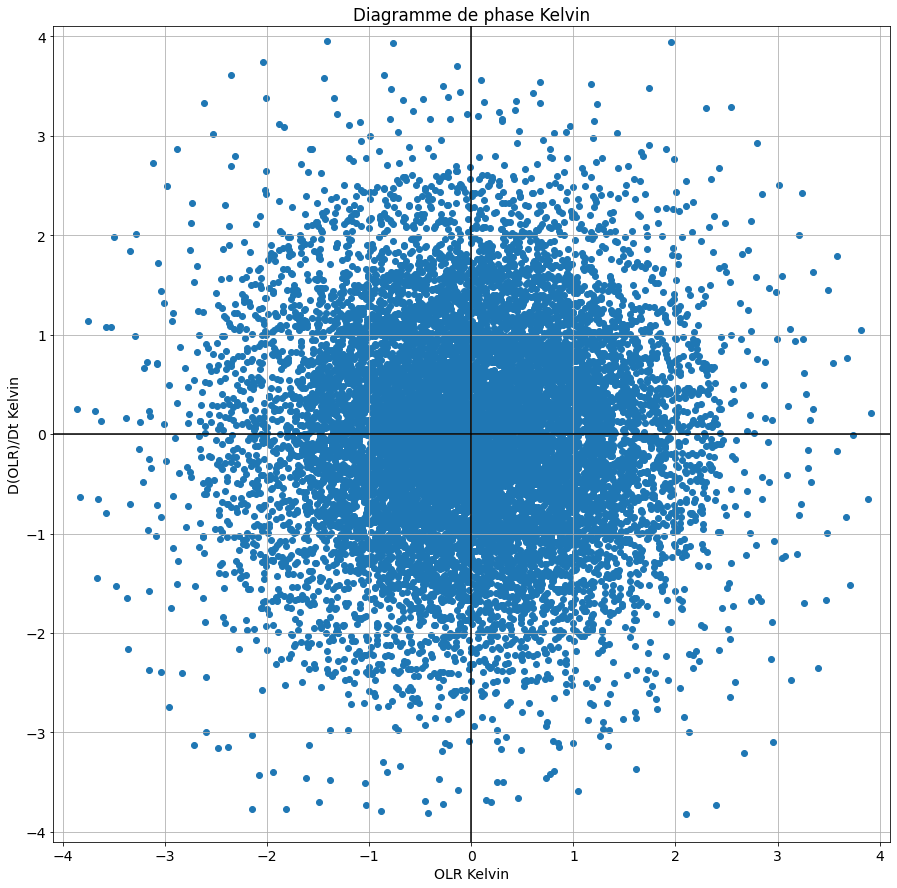

In [4]:

fig, axes = plt.subplots(figsize=(15,15))
# _ds_FILTER_mean = ds_FILTER_mean.sel(level = 850)
variable = ['MJO','TD','Kelvin','Rossby','MRG']
plt.rc("figure", figsize=(12,10))
ds_norm.plot.scatter(x = 'OLR_Kelvin', y = 'OLR_Kelvin_DT')
# __ds.sel( phase = 31).plot.scatter(x = 'vect_x', y = 'vect_y')
axes.set_ylabel('D(OLR)/Dt Kelvin')
axes.set_xlabel('OLR Kelvin')
axes.hlines(0, -250, 100, colors = 'black')
axes.vlines(0, -55, 55, colors = 'black')
axes.set_title('Diagramme de phase Kelvin')
axes.set_xlim(-4.1,4.1)
axes.set_ylim(-4.1,4.1)
axes.grid()

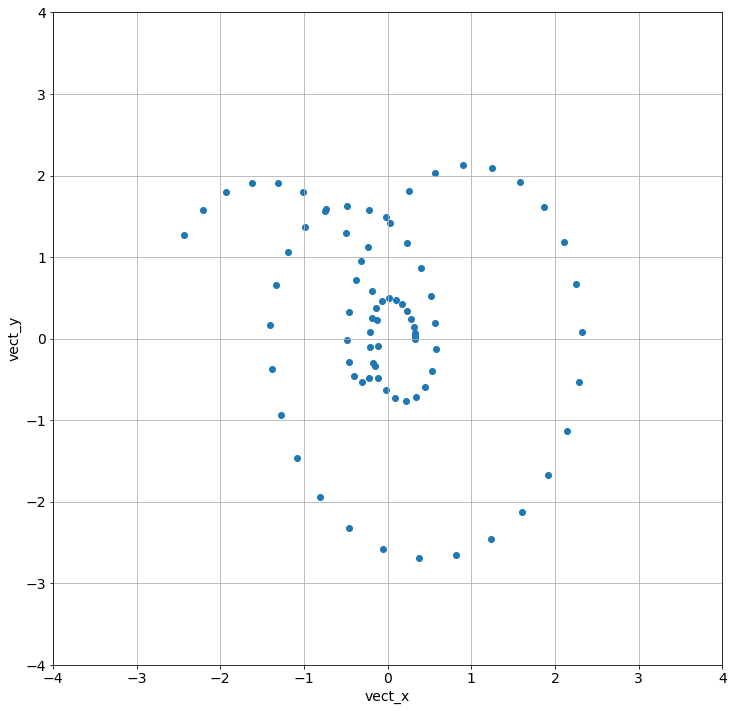

In [6]:
plt.rc("figure", figsize=(12,12))
ds_plot.sel(time=slice('2009-07-01','2009-07-10')).plot.scatter(x = 'vect_x', y = 'vect_y')
# ds_plot.sel(time=slice('2009-07-01','2009-07-10')).plot.scatter(x = 'std_circle_x', y = 'std_circle_y')
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.grid()
plt.show()

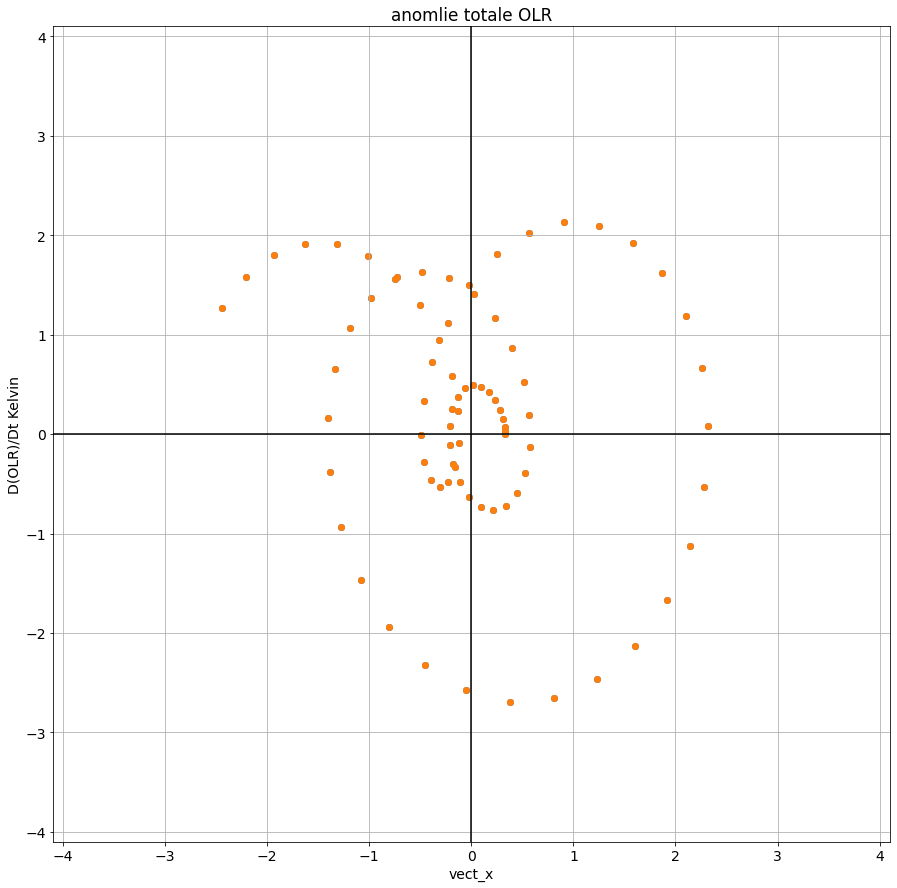

In [7]:
_wave = 'Kelvin'

fig, axes = plt.subplots(figsize=(15,15))
# _ds_FILTER_mean = ds_FILTER_mean.sel(level = 850)
variable = ['MJO','TD','Kelvin','Rossby','MRG']
plt.rc("figure", figsize=(12,10))
ds_norm.sel(time=slice('2009-07-01','2009-07-10')).plot.scatter(x = 'OLR_Kelvin', y = 'OLR_' + _wave + '_DT')
ds_plot.sel(time=slice('2009-07-01','2009-07-10')).plot.scatter(x = 'vect_x', y = 'vect_y')
axes.set_ylabel('D(OLR)/Dt ' + _wave)
axes.set_label('anomalie totale OLR')
axes.hlines(0, -250, 100, colors = 'black')
axes.vlines(0, -55, 55, colors = 'black')
axes.set_title('anomlie totale OLR')
axes.set_xlim(-4.1,4.1)
axes.set_ylim(-4.1,4.1)
axes.grid()
# plt.show()

In [4]:
ds = xr.open_mfdataset(indir_data + '*.nc', chunks = {'time' : 10})
_ds = ds.sel(time = np.in1d(ds['time.month'], months), lat = slice(-30,30), lon = 140.5)
# ds = ds.assign_coords(lon = (((ds.lon + 180) % 360) - 180)).sortby('lon')
# _ds = ds.sel(lat = slice(-19,19), lon = 0.5)
# _ds = _ds.mean(dim = ['lon'])

### Compute temporal derivative
ds_DDt = ds.differentiate('time', datetime_unit = "s")
_ds_DDt = ds_DDt.sel(time = np.in1d(ds_DDt['time.month'], months), lat = slice(-30,30), lon = 140.5)
# _ds_DDt = ds_DDt.sel(lat = slice(-19,19), lon = 0.5)
# _ds_DDt = _ds_DDt.mean(dim = ['lon'])

ds_std = _ds.std(dim = ['time','lat'])
ds_DDt_std = _ds_DDt.std(dim = ['time','lat'])

# Normalizing by standard deviation
ds_norm = _ds/ds_std
_ds_DDt = _ds_DDt/ds_DDt_std

### Stock in one datasets
for w in wave_OLR :
    ds_norm[w + '_DT'] = _ds_DDt[w]
    
### Compute variance of the data
ds_norm_std = ds_norm.std(dim = 'time')

v1 = ds_norm['OLR_Kelvin'].compute()
v2 = ds_norm['OLR_Kelvin_DT'].compute()

ds_plot = amplitudeMagnitude(v1, v2)

space_phase = np.linspace(np.pi, -np.pi, 33, endpoint = True)
d_space_phase = (space_phase[1] - space_phase[2])/2
space_phase = space_phase[:-1] - d_space_phase

nb_phase = np.linspace(0, 31, 32, dtype = 'int')

numpy_data = np.ones(shape = (ds_plot.time.size,nb_phase.size, ds_plot.lat.size)) * 0.
numpy_data.shape

__ds = xr.Dataset(
    data_vars=dict(
        amplitude = (["time", "phase", "lat"], numpy_data),
        magnitude = (["time", "phase", "lat"], numpy_data),
        vect_x = (["time", "phase", "lat"], numpy_data),
        vect_y = (["time", "phase", "lat"], numpy_data),
        std_circle_x = (["time", "phase", "lat"], numpy_data),
        std_circle_y = (["time", "phase", "lat"], numpy_data),
        std = 0.,
        
    ),
    coords=dict(
        lat = ds_plot.lat,
        phase=(["phase"], nb_phase),
        time=ds_plot.time,
    ),
    attrs=dict(description="Weather related data."),
)

In [9]:
demi1 = np.linspace(np.pi/2, -np.pi/2, 16, endpoint = False)
demi2 = np.linspace(-np.pi/2, -np.pi, 8, endpoint = False)
demi3 = np.linspace(np.pi, np.pi/2, 8, endpoint = False)

space_phase_plot = np.concatenate((demi1, demi2, demi3))
space_phase

array([ 3.04341788,  2.84706834,  2.6507188 ,  2.45436926,  2.25801972,
        2.06167018,  1.86532064,  1.6689711 ,  1.47262156,  1.27627202,
        1.07992247,  0.88357293,  0.68722339,  0.49087385,  0.29452431,
        0.09817477, -0.09817477, -0.29452431, -0.49087385, -0.68722339,
       -0.88357293, -1.07992247, -1.27627202, -1.47262156, -1.6689711 ,
       -1.86532064, -2.06167018, -2.25801972, -2.45436926, -2.6507188 ,
       -2.84706834, -3.04341788])

In [5]:
ampl = np.arctan2(v2,v1) ### arctan2 variable on y first, on x second
# ampl = np.arcsin(v2,v1)
magn = np.sqrt(v1**2 + v2**2)

ampl = ampl.rename('ampl')
magn = magn.rename('magn')
__ds['magnitude'] = magn

# std_circle = magn.std('time')
# std_circle = (magn * 0. + std_circle).persist()
# magn = magn.where(magn >= std_circle)

# __ds = __ds.mean(dim = 'lon')
__ds = __ds.transpose("time","lat","phase")

for i in range(nb_phase.size-1) :
    da = xr.where( ((ampl <=  space_phase[i]) & ( ampl > space_phase[i+1]) == True),
                                       ampl, np.nan)
    __ds['amplitude'][...,i+1] = da
    del da
    
da = xr.where( ((ampl <=  space_phase[-1]) | ( ampl > space_phase[0]) == True),
                                       ampl, np.nan)
__ds['amplitude'][...,0] = da 

__ds['magnitude'] = __ds['magnitude'].expand_dims(phase = __ds['phase'], axis = 2)
__ds['magnitude'] = xr.where(__ds['amplitude'].isnull() != True, __ds['magnitude'], np.nan)

__ds['vect_x'] = __ds['magnitude'] * np.cos(__ds['amplitude'])
__ds['vect_y'] = __ds['magnitude'] * np.sin(__ds['amplitude'])

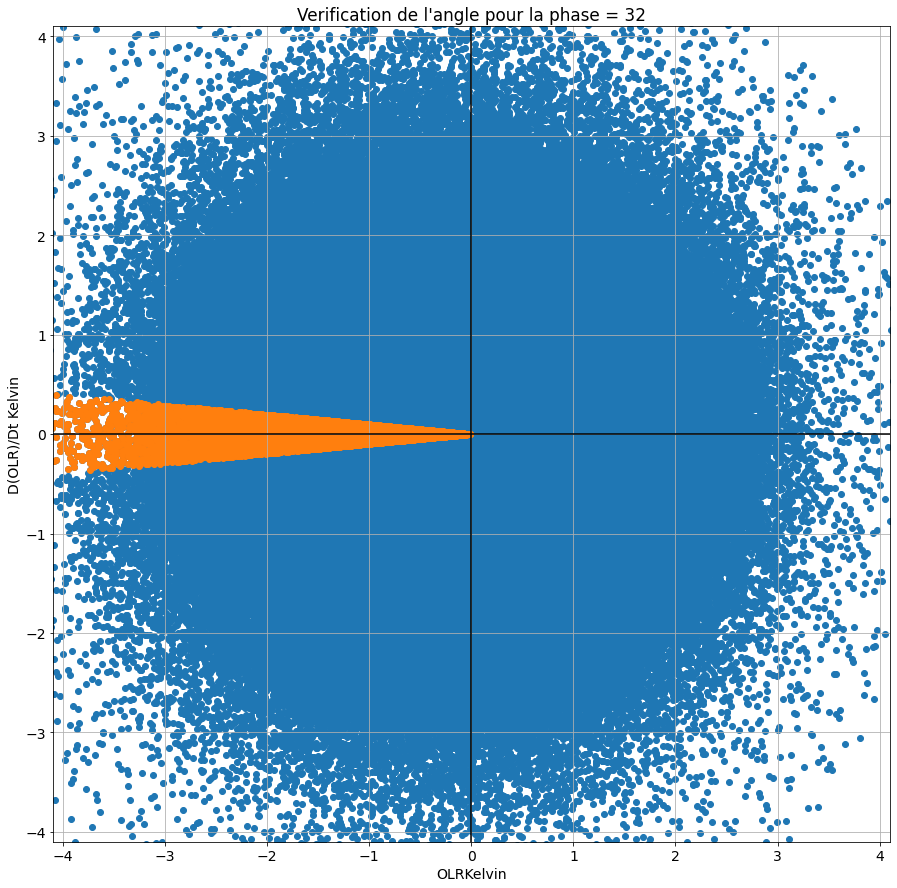

In [6]:
_wave = 'Kelvin'
fig, axes = plt.subplots(figsize=(15,15))
# _ds_FILTER_mean = ds_FILTER_mean.sel(level = 850)
variable = ['MJO','TD','Kelvin','Rossby','MRG']
plt.rc("figure", figsize=(12,10))
ds_norm.plot.scatter(x = 'OLR_Kelvin', y = 'OLR_' + _wave + '_DT')
__ds.sel( phase = 0).plot.scatter(x = 'vect_x', y = 'vect_y')
axes.set_ylabel('D(OLR)/Dt ' + _wave)
axes.set_xlabel('OLR' + _wave)
axes.hlines(0, -250, 100, colors = 'black')
axes.vlines(0, -55, 55, colors = 'black')
axes.set_title('Verification de l\'angle pour la phase = 32')
axes.set_xlim(-4.1,4.1)
axes.set_ylim(-4.1,4.1)
axes.grid()

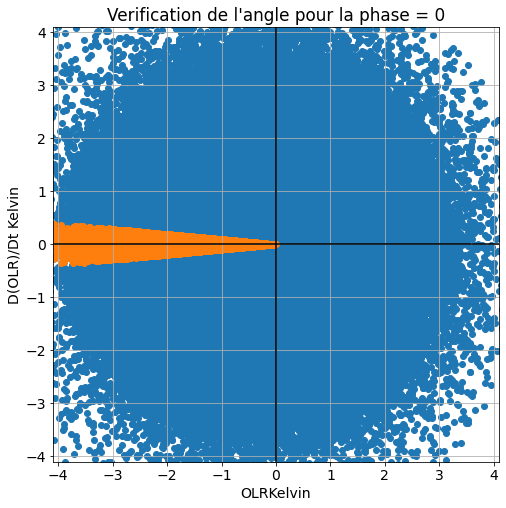

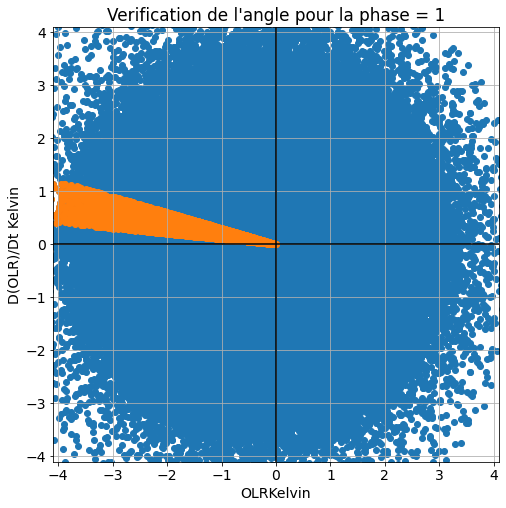

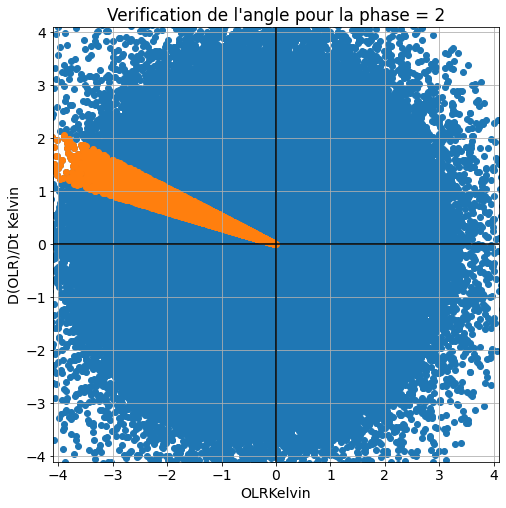

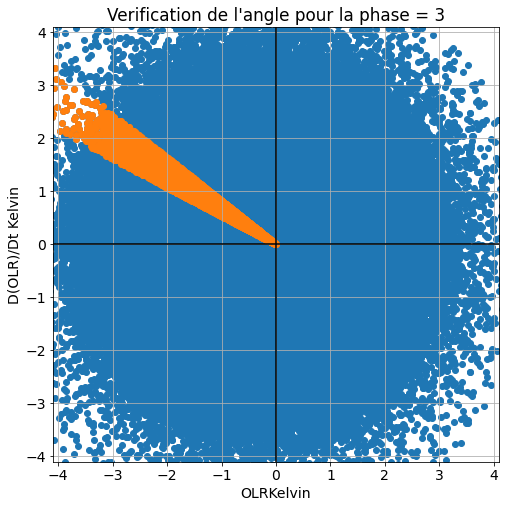

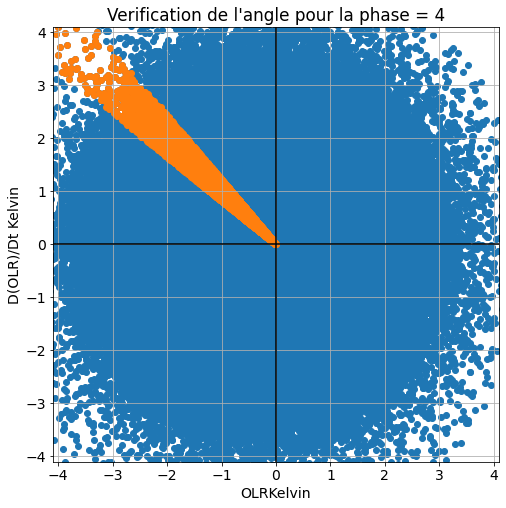

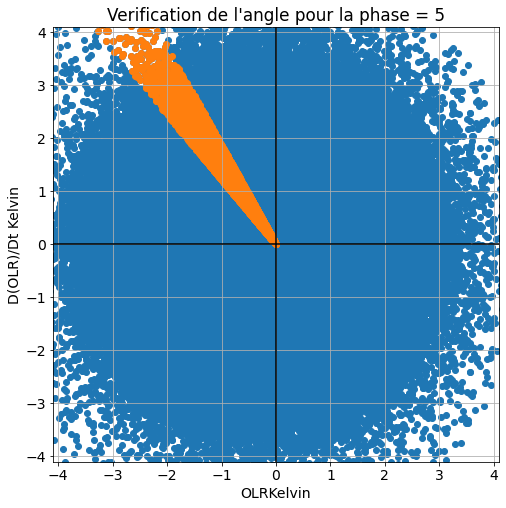

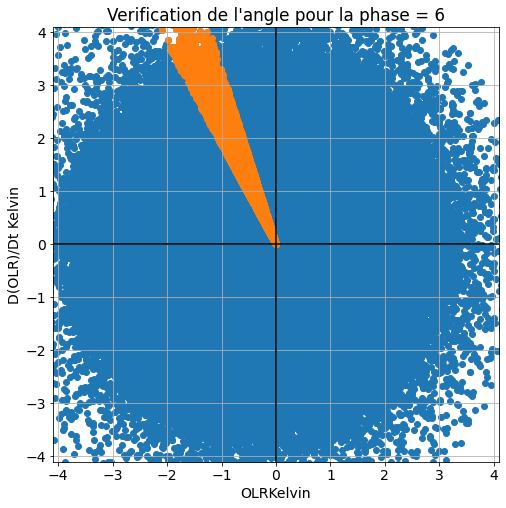

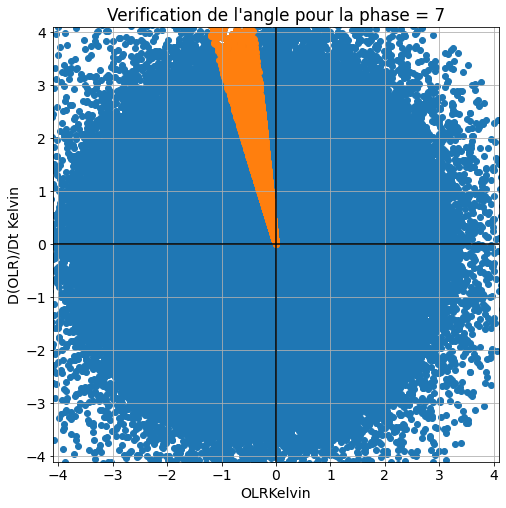

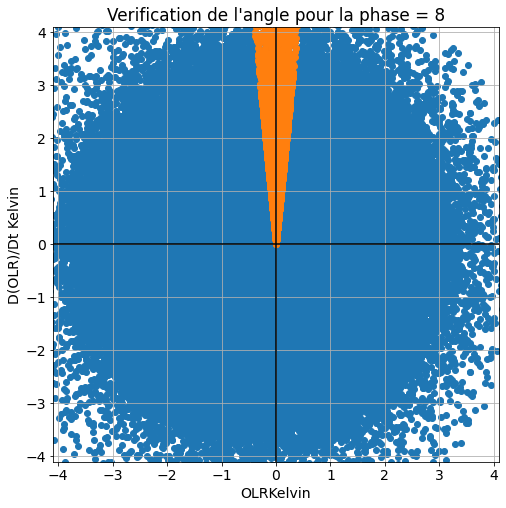

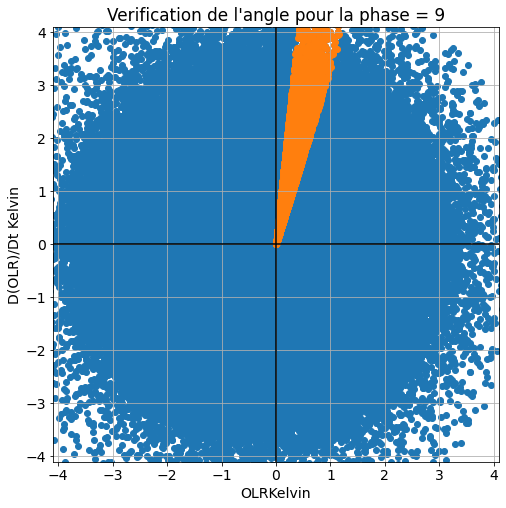

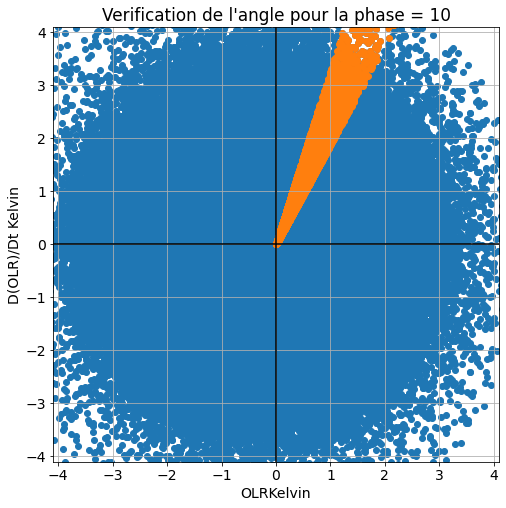

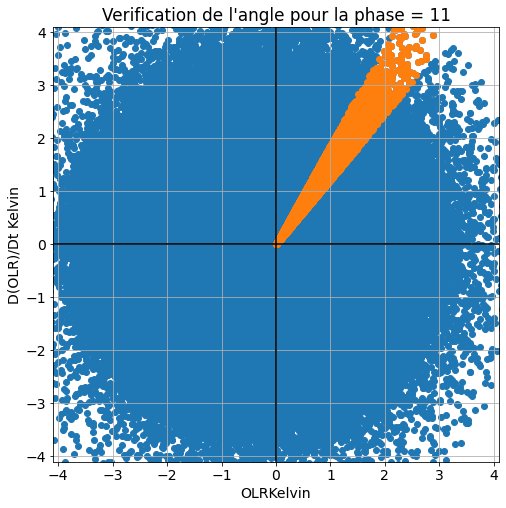

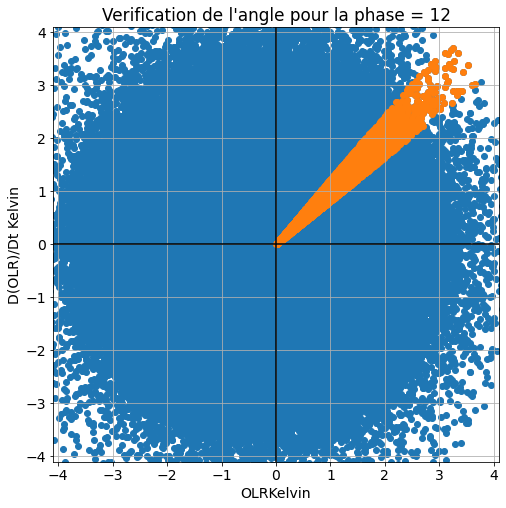

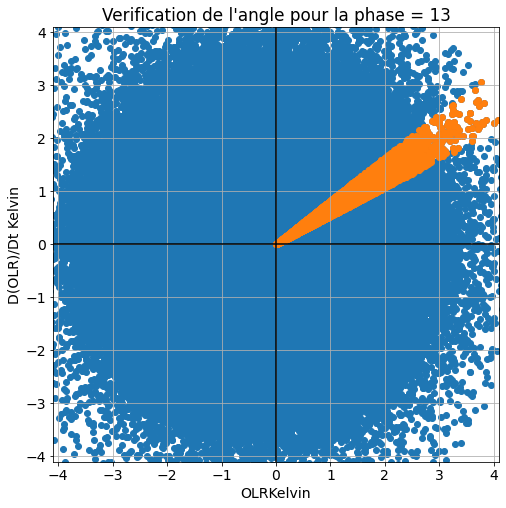

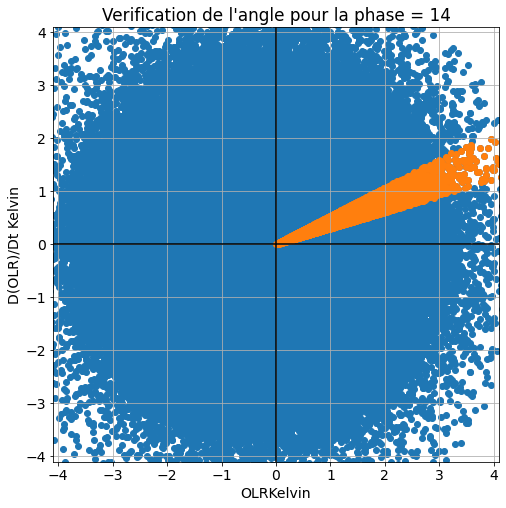

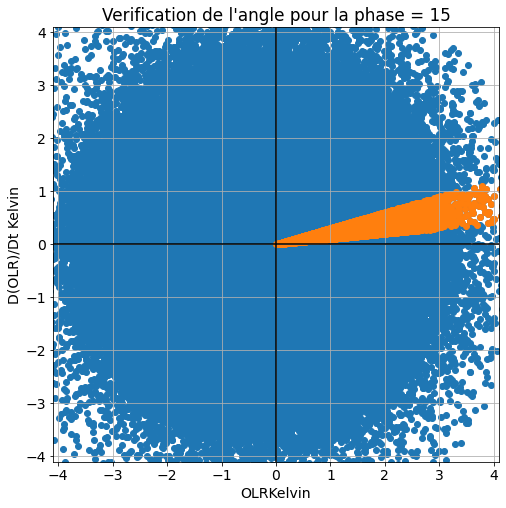

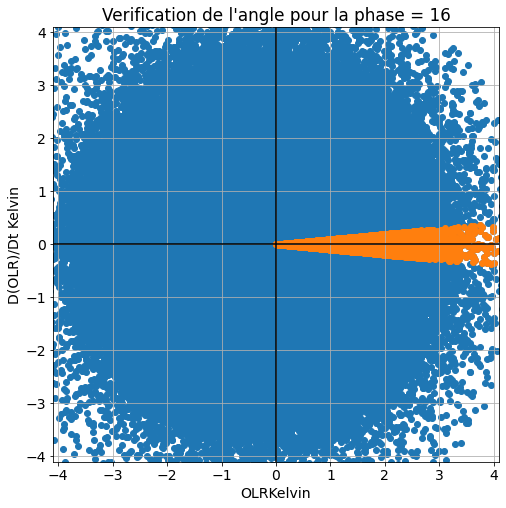

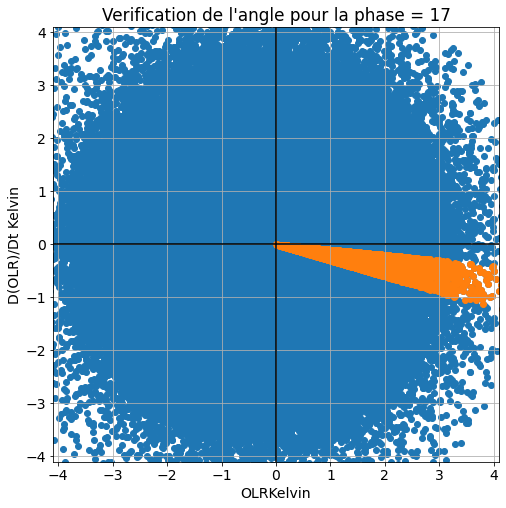

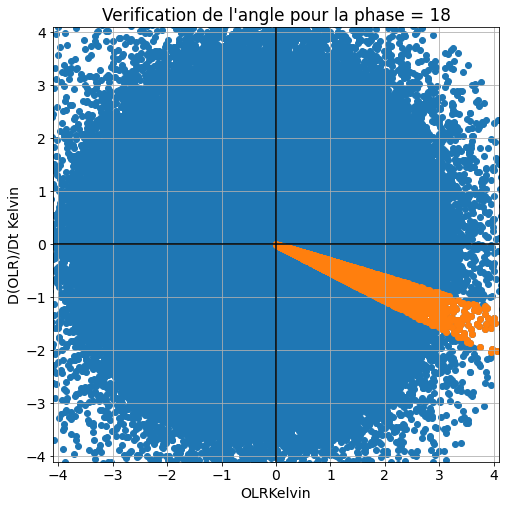

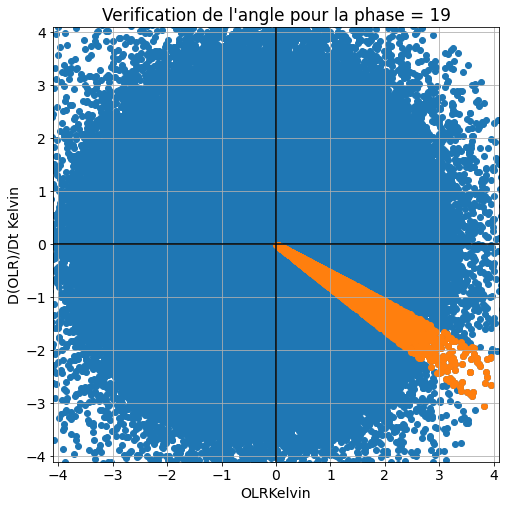

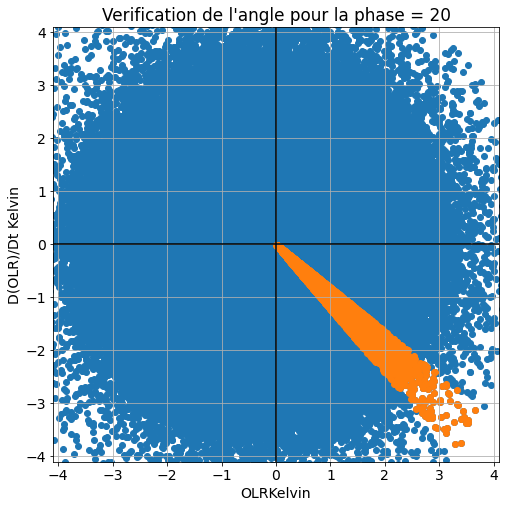

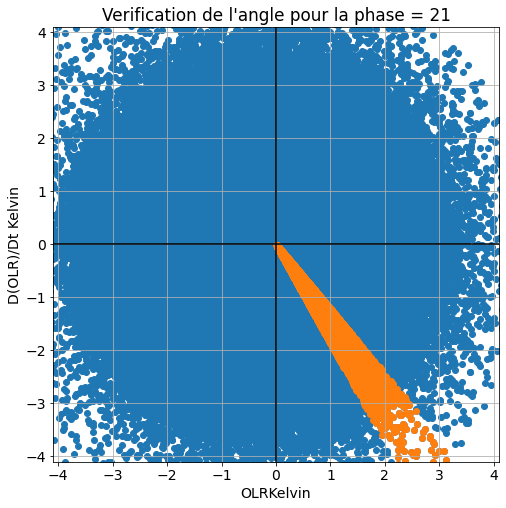

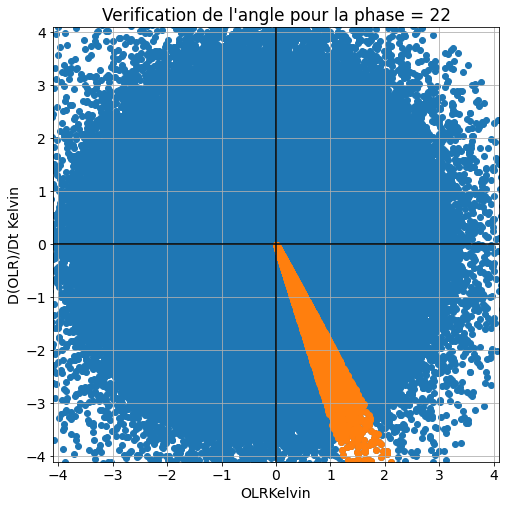

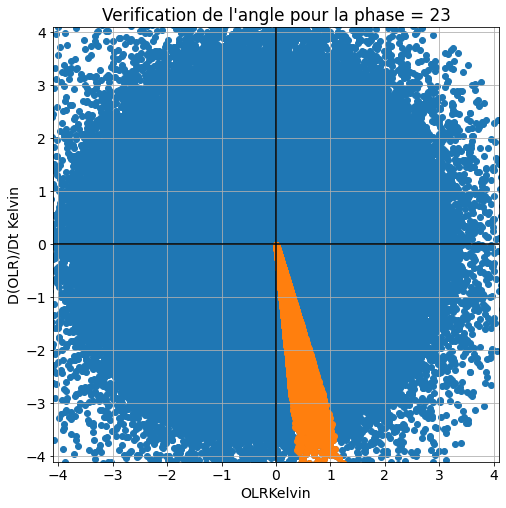

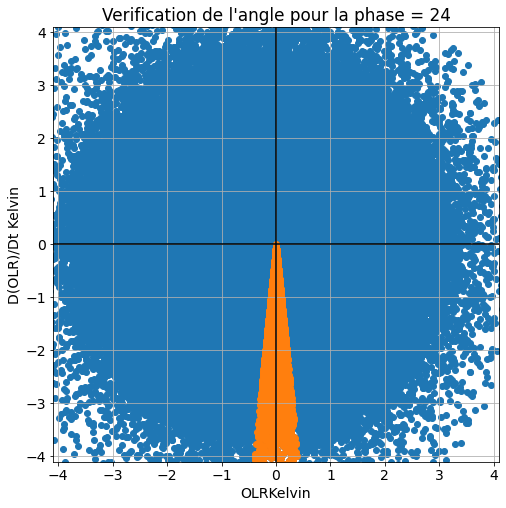

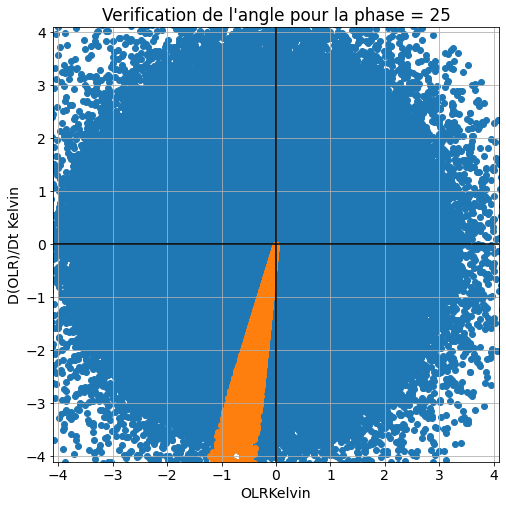

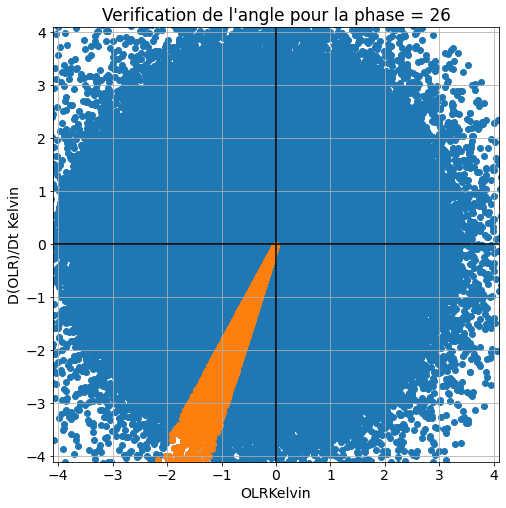

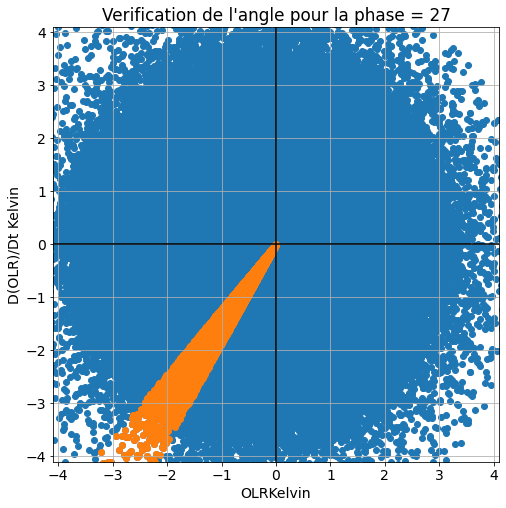

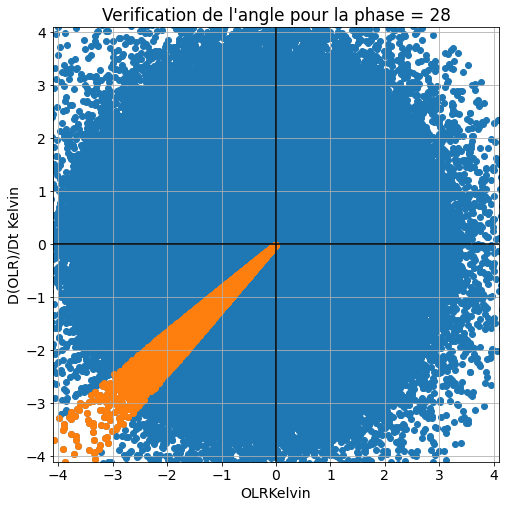

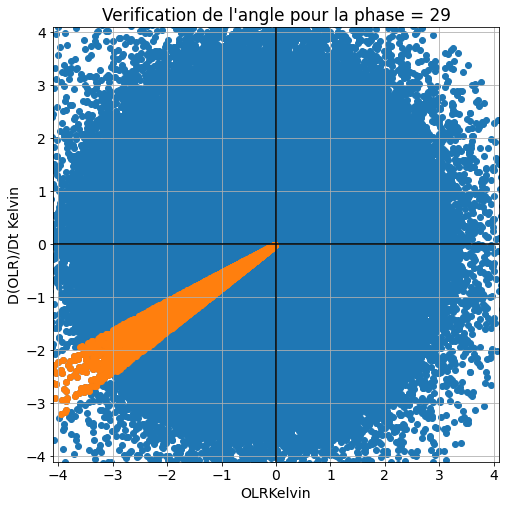

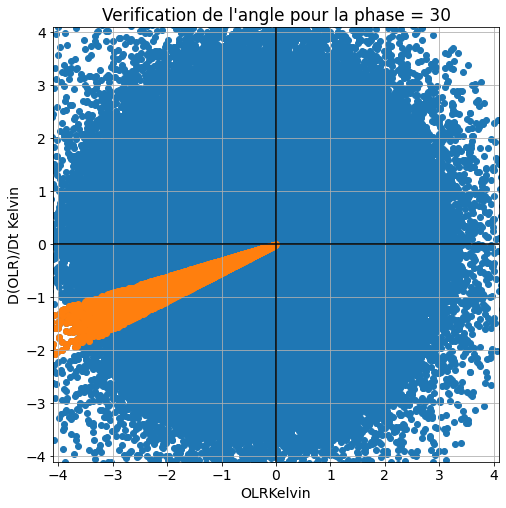

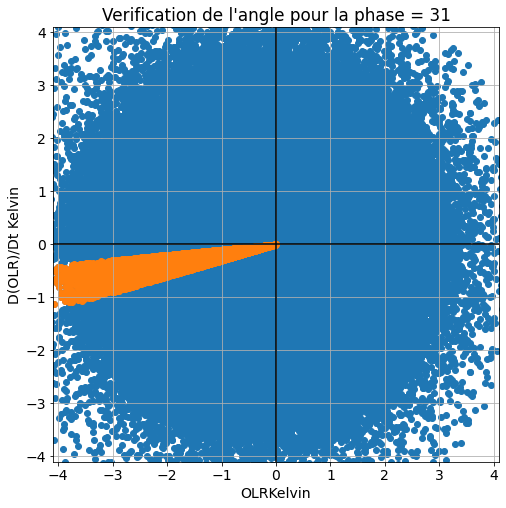

In [10]:
_wave = 'Kelvin'
for i in range(32):
    fig, axes = plt.subplots(figsize=(8,8))
    # _ds_FILTER_mean = ds_FILTER_mean.sel(level = 850)
    variable = ['MJO','TD','Kelvin','Rossby','MRG']
    plt.rc("figure", figsize=(12,10))
    ds_norm.plot.scatter(x = 'OLR_Kelvin', y = 'OLR_' + _wave + '_DT')
    __ds.sel( phase = i).plot.scatter(x = 'vect_x', y = 'vect_y')
    axes.set_ylabel('D(OLR)/Dt ' + _wave)
    axes.set_xlabel('OLR' + _wave)
    axes.hlines(0, -250, 100, colors = 'black')
    axes.vlines(0, -55, 55, colors = 'black')
    axes.set_title('Verification de l\'angle pour la phase = ' + str(i))
    axes.set_xlim(-4.1,4.1)
    axes.set_ylim(-4.1,4.1)
    axes.grid()
    plt.show()

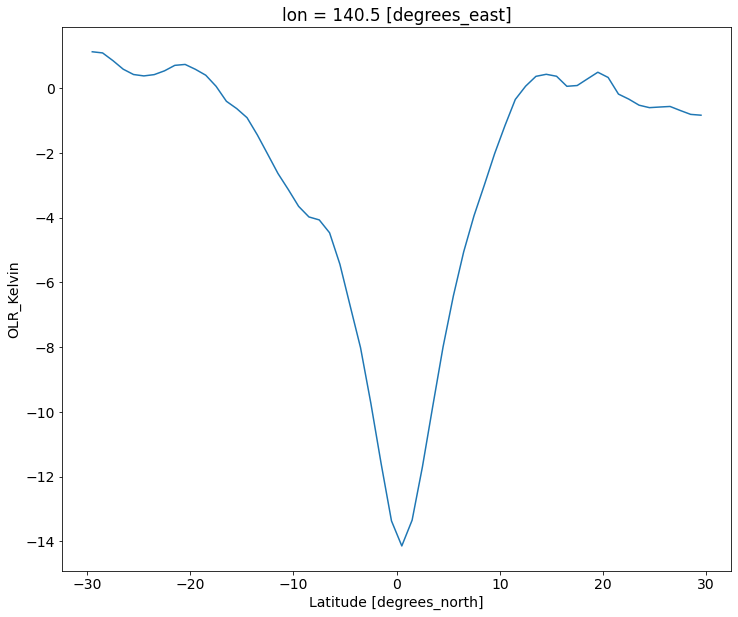

In [13]:
_ds_Test = __ds.sel(lat = 0, phase = 0, method = 'nearest')
_ds_Test = _ds_Test.dropna(dim = 'time')

_ds_2 = _ds.sel(time = _ds_Test.time.values)
_ds_2 = _ds_2.mean('time')
_ds_2['OLR_Kelvin'].plot()

In [14]:
_ds_Test = __ds['amplitude'].sel(lat = 0, method = 'nearest')
del _ds_Test['lat']
_ds_Test = _ds_Test.expand_dims(lat = _ds['lat'], axis = 1)

<xarray.DataArray 'amplitude' (time: 13248, lat: 60, phase: 32)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
    lon      float32 140.5
  * phase    (phase) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * time     (time) datetime64[ns] 2001-07-01 ... 2018-09-30T21:00:00

([<matplotlib.axis.XTick at 0x7ff7e1ac9190>,
 [Text(-8, 0, '$-\\pi$'),
  Text(0, 0, '$-\\pi/2$'),
  Text(7, 0, '0'),
  Text(15, 0, '$\\pi/2$'),
  Text(23, 0, '$\\pi$')])

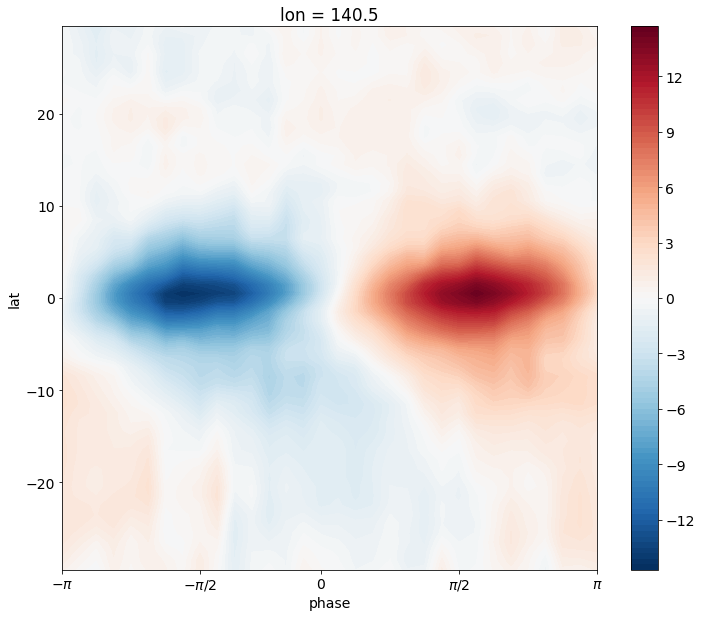

In [15]:
_ds_3 = _ds['OLR_Kelvin'].expand_dims(phase = __ds['phase'], axis = 2)
_ds_3 = xr.where(_ds_Test.isnull() != True,
                         _ds_3, np.nan)
_ds_3 = _ds_3.mean(dim = 'time').compute()

ds_4 = _ds_3.assign_coords(phase = ((_ds_3.phase + 8) % 32) - 8).sortby('phase')
ds_4

positions = (-8, 0, 7, 15, 23)
labels = ("$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$" )

plt.figure()
ds_4.plot.contourf(levels = 100)
plt.xticks(positions, labels)


In [16]:
v1 = ds_norm['OLR_Rossby'].compute()
v2 = ds_norm['OLR_Rossby_DT'].compute()

ds_plot = amplitudeMagnitude(v1, v2)

space_phase = np.linspace(np.pi, -np.pi, 33, endpoint = True)
d_space_phase = (space_phase[1] - space_phase[2])/2
space_phase = space_phase[:-1] - d_space_phase

nb_phase = np.linspace(0, 31, 32, dtype = 'int')

numpy_data = np.ones(shape = (ds_plot.time.size,nb_phase.size, ds_plot.lat.size)) * 0.
numpy_data.shape

__ds = xr.Dataset(
    data_vars=dict(
        amplitude = (["time", "phase", "lat"], numpy_data),
        magnitude = (["time", "phase", "lat"], numpy_data),
        vect_x = (["time", "phase", "lat"], numpy_data),
        vect_y = (["time", "phase", "lat"], numpy_data),
        std_circle_x = (["time", "phase", "lat"], numpy_data),
        std_circle_y = (["time", "phase", "lat"], numpy_data),
        std = 0.,
        
    ),
    coords=dict(
        lat = ds_plot.lat,
        phase=(["phase"], nb_phase),
        time=ds_plot.time,
    ),
    attrs=dict(description="Weather related data."),
)

ampl = np.arctan2(v2,v1) ### arctan2 variable on y first, on x second
magn = np.sqrt(v1**2 + v2**2)

ampl = ampl.rename('ampl')
magn = magn.rename('magn')
__ds['magnitude'] = magn

__ds = __ds.transpose("time","lat","phase")

for i in range(nb_phase.size-1) :
    da = xr.where( ((ampl <=  space_phase[i]) & ( ampl > space_phase[i+1]) == True),
                                       ampl, np.nan)
    __ds['amplitude'][...,i+1] = da
    del da
    
da = xr.where( ((ampl <=  space_phase[-1]) | ( ampl > space_phase[0]) == True),
                                       ampl, np.nan)
__ds['amplitude'][...,0] = da 

__ds['magnitude'] = __ds['magnitude'].expand_dims(phase = __ds['phase'], axis = 2)
__ds['magnitude'] = xr.where(__ds['amplitude'].isnull() != True, __ds['magnitude'], np.nan)

__ds['vect_x'] = __ds['magnitude'] * np.cos(__ds['amplitude'])
__ds['vect_y'] = __ds['magnitude'] * np.sin(__ds['amplitude'])

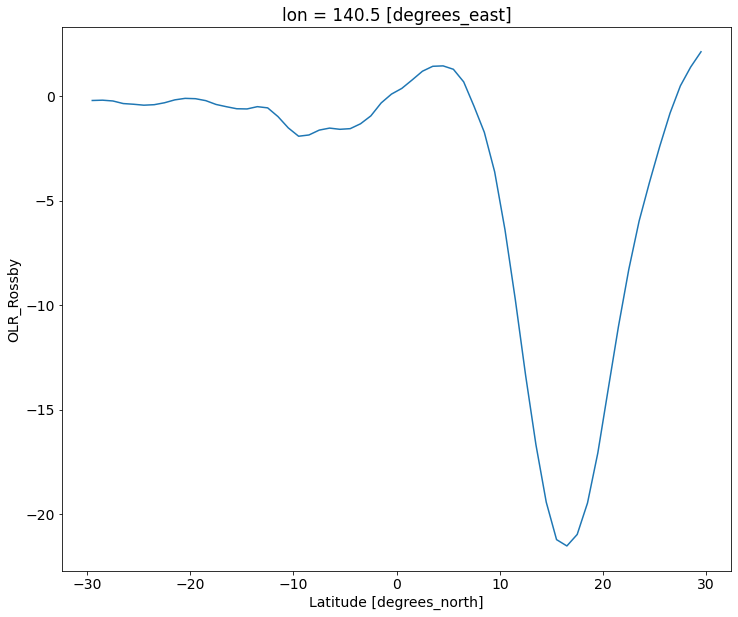

In [22]:
_ds_Test = __ds.sel(lat = 15, phase = 0, method = 'nearest')
_ds_Test = _ds_Test.dropna(dim = 'time')

_ds_2 = _ds.sel(time = _ds_Test.time.values)
_ds_2 = _ds_2.mean('time')
_ds_2['OLR_Rossby'].plot()

([<matplotlib.axis.XTick at 0x7ff7e982a670>,
 [Text(-8, 0, '$-\\pi$'),
  Text(0, 0, '$-\\pi/2$'),
  Text(7, 0, '0'),
  Text(15, 0, '$\\pi/2$'),
  Text(23, 0, '$\\pi$')])

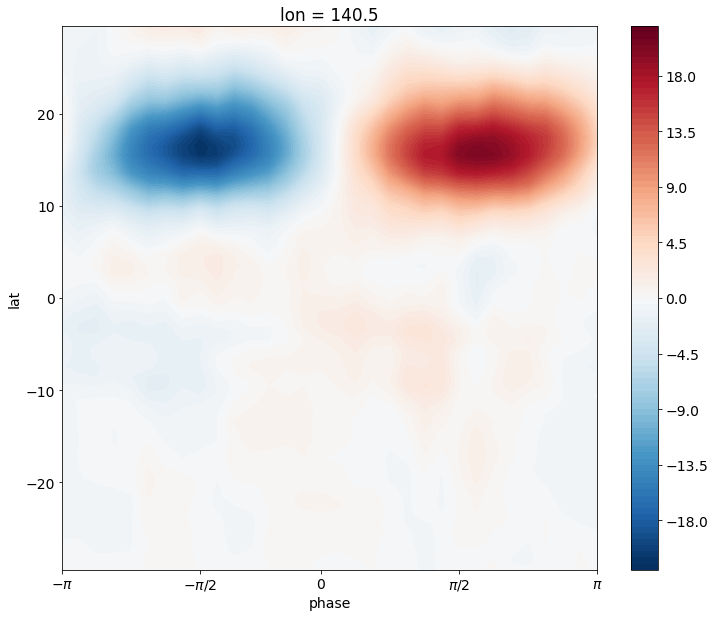

In [24]:
_ds_3 = _ds['OLR_Rossby'].expand_dims(phase = __ds['phase'], axis = 2)

_ds_Test = __ds['amplitude'].sel(lat = 15, method = 'nearest')
del _ds_Test['lat']
_ds_Test = _ds_Test.expand_dims(lat = _ds['lat'], axis = 1)

_ds_3 = xr.where(_ds_Test.isnull() != True,
                         _ds_3, np.nan)
_ds_3 = _ds_3.mean(dim = 'time').compute()

ds_4 = _ds_3.assign_coords(phase = ((_ds_3.phase + 8) % 32) - 8).sortby('phase')
ds_4

positions = (-8, 0, 7, 15, 23)
labels = ("$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$" )

plt.figure()
ds_4.plot.contourf(levels = 100)
plt.xticks(positions, labels)
